In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras

from tensorflow.keras import layers
from tensorflow.keras import losses

import matplotlib.pyplot as plt

2024-06-05 00:13:56.296997: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import mydata as md

data = md.Data('/home/alex/Data/datasets', 'cache')


In [3]:
#raw_train_ds, raw_validation_ds, raw_test_ds = data.get_tabiturient_data()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [4]:
raw_train_ds, raw_validation_ds, raw_test_ds = data.load('tabiturient')

In [5]:
#data.save('tabiturient', raw_train_ds, raw_validation_ds, raw_test_ds)

In [5]:
max_features = 20000
sequence_length = 600

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
#    ngrams=2,
    output_sequence_length=sequence_length
)

In [6]:
data.adapt(raw_train_ds, vectorize_layer)

2024-06-05 00:16:14.981318: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
len(vectorize_layer.get_vocabulary())

20000

In [9]:
train_ds = data.vectorize(raw_train_ds, vectorize_layer)
validation_ds = data.vectorize(raw_validation_ds, vectorize_layer)
test_ds = data.vectorize(raw_test_ds, vectorize_layer)


In [10]:
ltsm_embedding_dim=32

embedding_layer = tf.keras.layers.Embedding(
    input_dim=(max_features),
    output_dim=ltsm_embedding_dim,
    mask_zero=True
)
bidirectional_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
dense_layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=None)

model_lstm = tf.keras.Sequential([
    keras.Input(shape=(None,), dtype="int64"),
    embedding_layer,
    bidirectional_layer,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, kernel_regularizer=None)
])
model_lstm.summary()

model_lstm.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='rmsprop',
              metrics=['accuracy', 'F1Score'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 32)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 690,051 (2.63 MB)

 Trainable params: 690,051 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
train_ds_batch=train_ds.shuffle(len(train_ds), reshuffle_each_iteration=True).batch(64)
validation_ds_batch=validation_ds.batch(64)
test_ds_batch=test_ds.batch(64)


In [12]:
checkpoint_filepath = "models/checkpoint_tabiturient_model_lstm.weights.h5"

epochs = 10
history = model_lstm.fit(
    train_ds_batch,
    validation_data=validation_ds_batch,
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_weights_only=True,
            save_best_only=True
        )        
    ]
)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 474ms/step - F1Score: 0.2555 - accuracy: 0.4971 - loss: 1.0469 - val_F1Score: 0.2275 - val_accuracy: 0.5181 - val_loss: 1.0028
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 564ms/step - F1Score: 0.2347 - accuracy: 0.4875 - loss: 1.0100 - val_F1Score: 0.3386 - val_accuracy: 0.5682 - val_loss: 0.8863
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 34s 650ms/step - F1Score: 0.4413 - accuracy: 0.6290 - loss: 0.8696 - val_F1Score: 0.5218 - val_accuracy: 0.7187 - val_loss: 0.7347
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 687ms/step - F1Score: 0.5036 - accuracy: 0.6926 - loss: 0.7526 - val_F1Score: 0.5446 - val_accuracy: 0.7493 - val_loss: 0.5950
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 39s 745ms/step - F1Score: 0.5347 - accuracy: 0.7280 - loss: 0.6621 - val_F1Score: 0.5068 - val_accuracy: 0.6880 - val_loss: 0.6636
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 44s 830ms/step - F1Score: 0.5621 - accuracy: 0.7421 - loss: 0.6197 - val_F1Score: 0.5680 - val_accuracy: 0.7716 - val

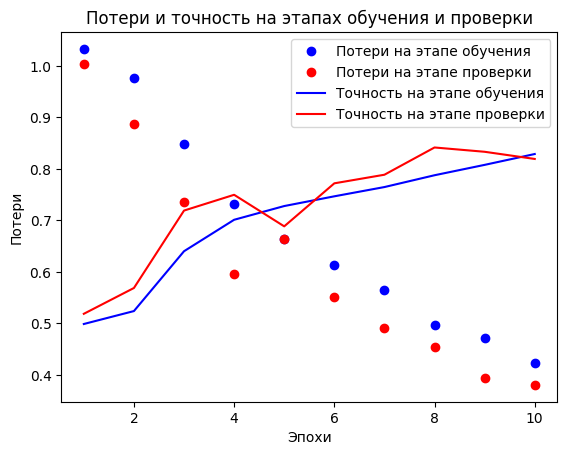

In [13]:
data.plot(history)

In [14]:
model_lstm.load_weights(checkpoint_filepath)

In [15]:
model_lstm.evaluate(test_ds_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - F1Score: 0.5036 - accuracy: 0.6481 - loss: 0.8537


[0.8537173271179199,
 0.6481481194496155,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.7199999, 0.       , 0.7906976], dtype=float32)>]

In [16]:
embedding_layer.trainable=False
bidirectional_layer.trainable=False

model_lstm_step2 = tf.keras.Sequential([
    keras.Input(shape=(None,), dtype="int64"),
    embedding_layer,
    bidirectional_layer,
    tf.keras.layers.Dropout(0.2),
    dense_layer,
    tf.keras.layers.Dense(3, kernel_regularizer='l2')
])
model_lstm_step2.summary()

model_lstm_step2.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='rmsprop',
              metrics=['accuracy', 'F1Score'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 32)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 698,115 (2.66 MB)

 Trainable params: 8,451 (33.01 KB)

 Non-trainable params: 689,664 (2.63 MB)

In [17]:
checkpoint_filepath = "models/checkpoint_tabiturient_model_lstm.weights.h5"

epochs = 10
history = model_lstm_step2.fit(
    train_ds_batch,
    validation_data=validation_ds_batch,
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_weights_only=True,
            save_best_only=True
        )        
    ]
)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 379ms/step - F1Score: 0.5476 - accuracy: 0.6919 - loss: 0.8026 - val_F1Score: 0.6318 - val_accuracy: 0.8050 - val_loss: 0.5328
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 381ms/step - F1Score: 0.6227 - accuracy: 0.7790 - loss: 0.5518 - val_F1Score: 0.7349 - val_accuracy: 0.8412 - val_loss: 0.4848
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 379ms/step - F1Score: 0.6969 - accuracy: 0.8168 - loss: 0.4844 - val_F1Score: 0.7601 - val_accuracy: 0.8440 - val_loss: 0.4636
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 413ms/step - F1Score: 0.7184 - accuracy: 0.8159 - loss: 0.4851 - val_F1Score: 0.7672 - val_accuracy: 0.8524 - val_loss: 0.4473
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 434ms/step - F1Score: 0.7215 - accuracy: 0.8107 - loss: 0.4822 - val_F1Score: 0.7667 - val_accuracy: 0.8524 - val_loss: 0.4385
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 439ms/step - F1Score: 0.7437 - accuracy: 0.8209 - loss: 0.4802 - val_F1Score: 0.7961 - val_accuracy: 0.8663 - val

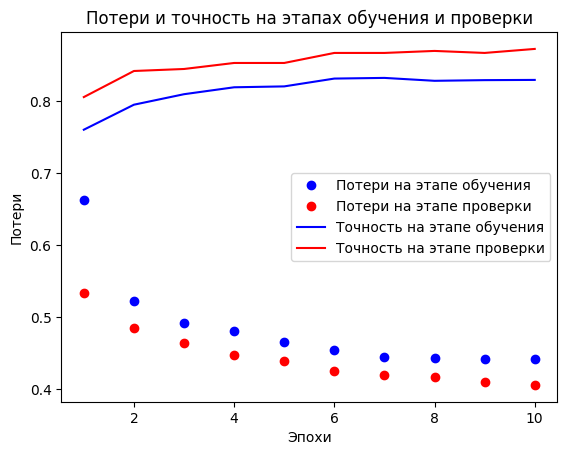

In [18]:
data.plot(history)

In [19]:
model_lstm_step2.load_weights(checkpoint_filepath)

In [20]:
export_model_lstm = tf.keras.Sequential([
  vectorize_layer,
  model_lstm_step2,
  tf.keras.layers.Activation('softmax')
])

export_model_lstm.compile(
    loss=losses.CategoricalCrossentropy(from_logits=False), optimizer="rmsprop", metrics=['accuracy', 'F1Score']
)

export_model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │       698,115 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 698,115 (2.66 MB)

 Trainable params: 8,451 (33.01 KB)

 Non-trainable params: 689,664 (2.63 MB)

In [21]:
model_lstm_step2.evaluate(
    test_ds_batch,
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - F1Score: 0.6012 - accuracy: 0.6667 - loss: 1.0054


[1.0053726434707642,
 0.6666666865348816,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.7272727, 0.2857142, 0.7906976], dtype=float32)>]

In [23]:
s0 = data.lemmatize('''
Много негативных эмоций связано с этим местом, потерял лучшие годы просто зря. В основном потому, что разрекламированный ВУЗ вообще ничего полезного не дал, только тупую зубрежку и устаревшие данные. По большей части это вина преподавателей, а именно их преклонного возраста. Людям хорошо за шестьдесят, а то и семьдесят, многие уже плохо ориентируются в своих знаниях, отчего падает качество обучения. Самые яркие моменты, которые определили мое отношение:
Первый момент - пожилые преподаватели часто не замечают ошибки ил находят их там, где решено правильно. Мой друг отвечал передо мной, и преподавателю показалось, что друг сказал другое число (хотя ответ был верным), в результате он поставил ему тройку и прогнал, все в шоке были, нас даже не захотели слушать.
Второй момент - к старости портится характер, из за чего следуют беспричинные придирки. На втором семестре второго курса один наш одногруппник пропустил две недели в начале без уважительной причины и профессор, которому было уже почти восемьдесят, запомнил его и постоянно цеплялся. Каждую пару он едва его видел, сразу задавал ему вопросы из тем, которые мы еще даже не начинали, а после ставил этому студенту двойку. Вся группа была в шоке, но ничего сделать мы не смогли, даже деканат не помог, в результате к сессии этот парень пришел почти с одними пятерками везде, только две четверки были, и по предмету этого преподавателя у него одни двойки буквально. Уже после летних каникул я узнал, что того студента все же отчислили
Да и сами знания давно не актуальные, нас заставляли чертить от руки, вычислять интегралы, хотя это давно делается на компьютере. Я получил диплом и понимаю, что мой уровень это инженерия 1970-х годов, на рынке труда я вообще не конкурентноспособен
''')

In [24]:
s1 = data.lemmatize('''
Коротко: крепкое техническое образование с душком нафталина и просто ошеломительно-отвратительный менеджмент.
Факультет МТ, кафедра МТ-11 "Наноинженерия". Поступала я в далеком 2015 году, отчислилась по собственному желанию в середине 3 курса (с одной тройкой - по дет.машу и единственным хвостом по физкультуре), потому что решила отдать предпочтение работе. В 2022 году пришлось восстанавливаться для перевода в другой вуз, дабы добить корочку, т.к. понадобилась для повышения. И я бы ни слова не написала про альма-матер, если бы не процесс восстановления. Ребята, если вы думаете, что вы знаете, что такое поганый менеджмент, подумайте еще раз.
Немного (полезного) о самом ВУЗЕ:
Если идете в МГТУ на техническую специальность, то готовьтесь посвящать всего себя учебе. Никакой +- адекватной работы совмещать не получится, насыщенная личная жизнь тоже не светит. За посещениями следить будут жестоко и беспощадно до абсурда - можно неиронично иметь единственным хвостом физкультуру. Даже если вы честно болели, даже если принесли справку. Отрабатывать придется упорно и мучительно. По остальным специальностям - считают посещения и могут не допустить до сдачи экзамена, если много прогуляли.
Качество преподавания разнится и зависит от преподавателя. Некоторые - просто бриллианты, некоторые, мягко говоря, не очень, некоторые не справляются в силу преклонного возраста.

Но это все меркнет на фоне МЕНЕДЖМЕНТА. Если Вам не посчастливится (а рано или поздно Вы с этим столкнетесь) вписаться в какой-либо вопрос с документами, пристегните ремни.

1) Очереди в деканат и к инспекторам есть всегда, за любой подписью вам придется стоять очень долго. Про очереди на оформление социальной стипендии в приличном обществе вообще не стоит говорить вслух.
2) Если у вас не очень стандартный вопрос, готовьтесь к тому, что никто ничего не знает. Так получилось, что у меня поменялась фамилия за то время, что я была отчислена. При написании заявления на восстановление я уточнила у ОТВЕТСТВЕННОГО ПО ВОССТАНОВЛЕНИЯМ И ПЕРЕВОДАМ на кафедре, как мне заполнять форму (т.к. в базе вуза я под одной фамилией и с одними паспортными данными, а паспорт уже новый). На что он мне сказал: "Я не знаю". И мы импровизировали, т.к. ответа не знал никто.
3) С обходными листами и вообще любыми бумажками, где нужно > 1 подписи, вам придется бегать под всему вузу самостоятельно. Закладывайте сразу несколько дней (а лучше неделю), т.к. многие сотрудники не подпишут бумаги день в день, вы оставите документ на подпись и вернетесь за ним на следующий день, чтобы нести в следующий кабинет.
4) Всем плевать на ваше время. И вообще на время. Расписание работников деката не значит, что сотрудник будет на рабочем месте. Это значит, что может быть, в промежутке +- полчаса он там появится. (К инспекторам это не относится, они работают четко как часы).
4.5) Отдельно хочу отметить вышеупомянутого Ответственно по переводам, которого пришлось ловить более 2 недель, т.к. (при звонке заранее) он НЕ ЗНАЛ, когда точно будет на месте. Что не очень удобно, если вы не студент, потому что а) нужно заказывать пропуск в универ заранее б) отпрашиваться на работе
5) Хамство. Касается не всех, но если коснется, будет горячо. При оформлении восстановления одна из работниц ВУЗА (прим. НЕ в деканате, а при сборе подписей на заявления) ко мне прицепилась секретарь (видимо) сотрудника, который должен был подписать документ и начала на меня ОРАТЬ, что "я себя не уважаю, раз перевожусь из ТАКОГО вуза, с ТАКОЙ специальности в сомнительный вуз, и как вообще таким людям дают работу". При том, что я к ней даже не обращалась, с ней разговаривать не начинала, и никакого отношения к моим документам она не имеет.
6) Невероятно долгий документооборот. Студенту потребуется как минимум неделя, чтобы получить справку об обучении. В моем специфическом случае процесс восстановления -смены фамилии в базе - перевода занял почти 2(!) месяца.

Вместо послесловия. Если Вы хотите заниматься наукой, готовы 6 дней в неделю проводить в любимой шарге и вы 100% не планируете работать во время учебы, этот вуз для Вас. Пара таких моих бывших одногруппников сейчас учатся в аспирантуре и довольны. Если Вы не подходите хотя бы по одному из пунктов, подумайте еще раз. Может быть, стоит пойти в вуз полегче и не тратить силы, здоровье и нервы. Ну, и если Вы идете только потому что "это престижный вуз, а инженер - отличная специальность", а сами не знаете, чего хотите - обходите стороной.
''')

In [25]:
s2=data.lemmatize('''
Выпускник ИУ-5 бакалавра 2022 года. О Бауманке бесконечное множество разношерстных мнений и отзывов. Как минимум, так на сайте "Табитуриента". Я не буду и не могу говорить за все специальности, скажу про ИУ, конкретно, про ИУ-5. Кафедра сильная, слабее, конечно, чем ИУ-7, так как там все-таки больше программного программирования и гораздо глубже изучается разработка, но зато преподаватели на ИУ-5 более спокойные и не пытаются довезти студентов до сумасшествия. Учиться сложно, реально сложно, но если прям учиться, а не страдать ерундой. Как уже писал один молодой человек в отзывах: "Отчислить всех нельзя, приходится доучивать", поэтому есть студенты, которые вымучивают тройки на сессиях и бегают в начале каждого семестра с 3-5 долгами с предыдущего. Могу сказать сразу, "Жестко программировать" вас не научат на кафедре. Она все же дает более обширные знания по специальности. Конечно, вы потрогаете и Assembler (правда зачем?), и C++, и C#, и Python, особенно много времени уделяется машинному обучению на Питоне, коснетесь веб-разработки, но прям супер-программистом на кафедре не станете. Но это нормально, ведь для этого существует великолепная вещь - ";Технопарк", совместный проект Бауманки и Mail.Ru. Вот в технопарке вас научат всему, оттуда точно выйдете топ-разработчиками. Учиться там могут только студенты МГТУ, поэтому идти в Бауманку стоит хотя бы ради этого, оно того стоит, уж поверьте. В этом году на кафедре поменялся заведующий, отсюда сразу изменения в программе магистратуры и, в дальнейшем, бакалавриата. Изменения очень серьезные, кафедра уходит все больше в нейронки, машинное обучение, что не может не радовать, как раз набирают под это дело новый преподавательский состав. Конечно, в ВУЗе много преподавателей в возрасте, ну и конечно есть дисциплины, которые, на мой субъективный взгляд, уже не нужны, так как чисто технически устарели, но такое везде, да и их все равно потихоньку заменяют. Сам в столовой стал питаться только на последнем курсе, так как времени реально мало (обеденных перерывов в Бауманке нету), но еда вполне себе неплохая, на 180-220 рублей можно вполне себе наесться. В кафешках, конечно, дорого, тот же сэндвич обойдется уже в 180 рублей. Гуманитарные предметы, наверное, не считая правоведения, бессмысленные, знаний там, конечно, особо не дают, но технические все более-менее на уровне. Многие пишут, что "тупая зубрежка диффуров и интегралов никому не нужна", могу на этот счет высказаться так - МГТУ - это университет, и тут есть базовые предметы, которые просто должны быть по определению, иначе ВУЗ не назывался бы университетом, да и "зубрить" такое не обязательно, важно понимать, а это разница. Деканат и так, по факту, пошел навстречу студентам и убрал сопромат и химию, что, наверное, хорошо, так как специальность все-таки IT. Из минусов отдельным издевательством является физкультура, до которой надо еще успеть добраться, а если она еще и в Измайлово, или у вас бассейн, то это вообще провал. Но ее, вроде как, собираются убрать из обязательных дисциплин, так что жить можно. В целом, отучившись в МГТУ, вы получите очень неплохую корочку, если еще и Технопарк закончите, то вообще идеально. Советую идти на ИУ-7, ИУ-5, ИУ-8, ИУ-9.
''')

In [26]:
s=data.lemmatize('''
Хорошая подготовка к жизни отличные преподаватели
''')

In [27]:
export_model_lstm.predict(tf.data.Dataset.from_tensor_slices([[[s]]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


array([[0.27774665, 0.2996199 , 0.4226334 ]], dtype=float32)

In [42]:
export_model_lstm.save('models/tabiturient_export_model_lstm.keras')

In [116]:
kinopoisk_export_model_lstm=keras.models.load_model('models/kinopoisk_export_model_lstm.keras')

/home/alex/ai_venv_2/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [117]:
kinopoisk_export_model_lstm.predict(tf.data.Dataset.from_tensor_slices([[[s0],[s1],[s2]]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


array([[0.8028376 , 0.18776289, 0.00939948],
       [0.27647188, 0.7113765 , 0.01215161],
       [0.02612451, 0.43212238, 0.5417531 ]], dtype=float32)

In [119]:
kinopoisk_export_model_lstm.compile(
    loss=losses.CategoricalCrossentropy(from_logits=False), optimizer="rmsprop", metrics=['accuracy', 'F1Score']
)

In [120]:
kinopoisk_export_model_lstm.evaluate(
    x=test_raw_text_data,
    y=test_label_data,
)

ValueError: Cannot get result() since the metric has not yet been built.

In [34]:
len(test_ds)

54